# Load Data

In [ ]:
import pandas as pd
import numpy as np

# Definisikan path file
path = '/content/drive/MyDrive/Colab Notebooks/RisetHibahPemerintah/Eksperimen - Klasifikasi Teks/'

data = pd.read_csv(path + 'datamodel_klasifikasi_clean.csv')
df = data[['Answer_fix', 'topik']].copy()

In [ ]:
df['Answer_fix'] = df['Answer_fix'].apply(eval)  # Konversi string list ke list

In [ ]:
df.head()

,Answer_fix,topik
0,"[insomnia, sakit, gejala, sakit, sakit, mental...",depresi
1,"[asa, debar, debar, irama, jantung, atur, otot...",stres
2,"[paham, asa, anak, tua, cerai, mudah, terkadan...",depresi
3,"[maria, prihatin, kondisi, alami, pengaruh, am...",depresi
4,"[depresi, bentuk, mental, perhati, masyarakat,...",depresi


In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences=df['Answer_fix'], vector_size=100, window=5, min_count=1)
X_w2v = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0) for words in df['Answer_fix']])

# setting data
nama_ekstraksi = 'X_w2v'
fitur = X_w2v
y = df['topik']

In [ ]:
# Mengecek jumlah nilai unik (jumlah fitur) dalam X_ngram
jumlah_fitur = X_w2v.shape[1]

print(f"Jumlah nilai unik (fitur) dalam X_w2v: {jumlah_fitur}")

Jumlah nilai unik (fitur) dalam X_w2v: 100


# import modul

In [ ]:
!pip install sklearn-genetic-opt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.1 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
import json
import nltk

# Pastikan nltk sudah terinstall
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous

In [ ]:
import joblib
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn_genetic")

# Ganti backend joblib
joblib.parallel_backend('threading')

# Setel variabel lingkungan untuk joblib
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'
os.environ['JOBLIB_PARALLEL_BACKEND'] = 'threading'

# BC SplitV modelling

In [ ]:
# Define models
models = {
    'Naive Bayes': GaussianNB(var_smoothing=1e-9),
    'KNN': KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='auto', p=2),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, min_samples_leaf=2, bootstrap=True),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=5)
}

# Bagging classifier
optimasi = 'BC optimization'
def get_bagging_clf(base_estimator):
    return BaggingClassifier(estimator=base_estimator, n_estimators=10, random_state=42, n_jobs=-1)

In [ ]:
# Define split ratios
splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

# Initialize results dictionary
results = {}

for train_size, test_size in splits:
    print(f'Processing split {int(train_size*100)}:{int(test_size*100)}')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fitur, y, test_size=test_size, random_state=42)

    for model_name, model in models.items():
        print(f'  Training {model_name} with Bagging Classifier')

        # Create Bagging Classifier with the current model
        bagging_clf = get_bagging_clf(model)
        bagging_clf.fit(X_train, y_train)
        y_pred = bagging_clf.predict(X_test)

        # Evaluation
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        # Convert tuple key to string
        result_key = f"{model_name}_{optimasi}_split {int(train_size*100)}:{int(test_size*100)}"

        # Save results
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_bc_sv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing split 60:40
  Training Naive Bayes with Bagging Classifier
    Accuracy: 0.7135
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.69      0.60      0.64       397
     depresi       0.70      0.83      0.76       591
       stres       0.76      0.66      0.71       506

    accuracy                           0.71      1494
   macro avg       0.71      0.70      0.70      1494
weighted avg       0.72      0.71      0.71      1494

  Training KNN with Bagging Classifier
    Accuracy: 0.7403
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.74      0.61      0.67       397
     depresi       0.73      0.85      0.79       591
       stres       0.75      0.72      0.73       506

    accuracy                           0.74      1494
   macro avg       0.74      0.72      0.73      1494
weighted avg       0.74      0.74      0.74      1494

  Training Random Forest with Bag

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_bc_sv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

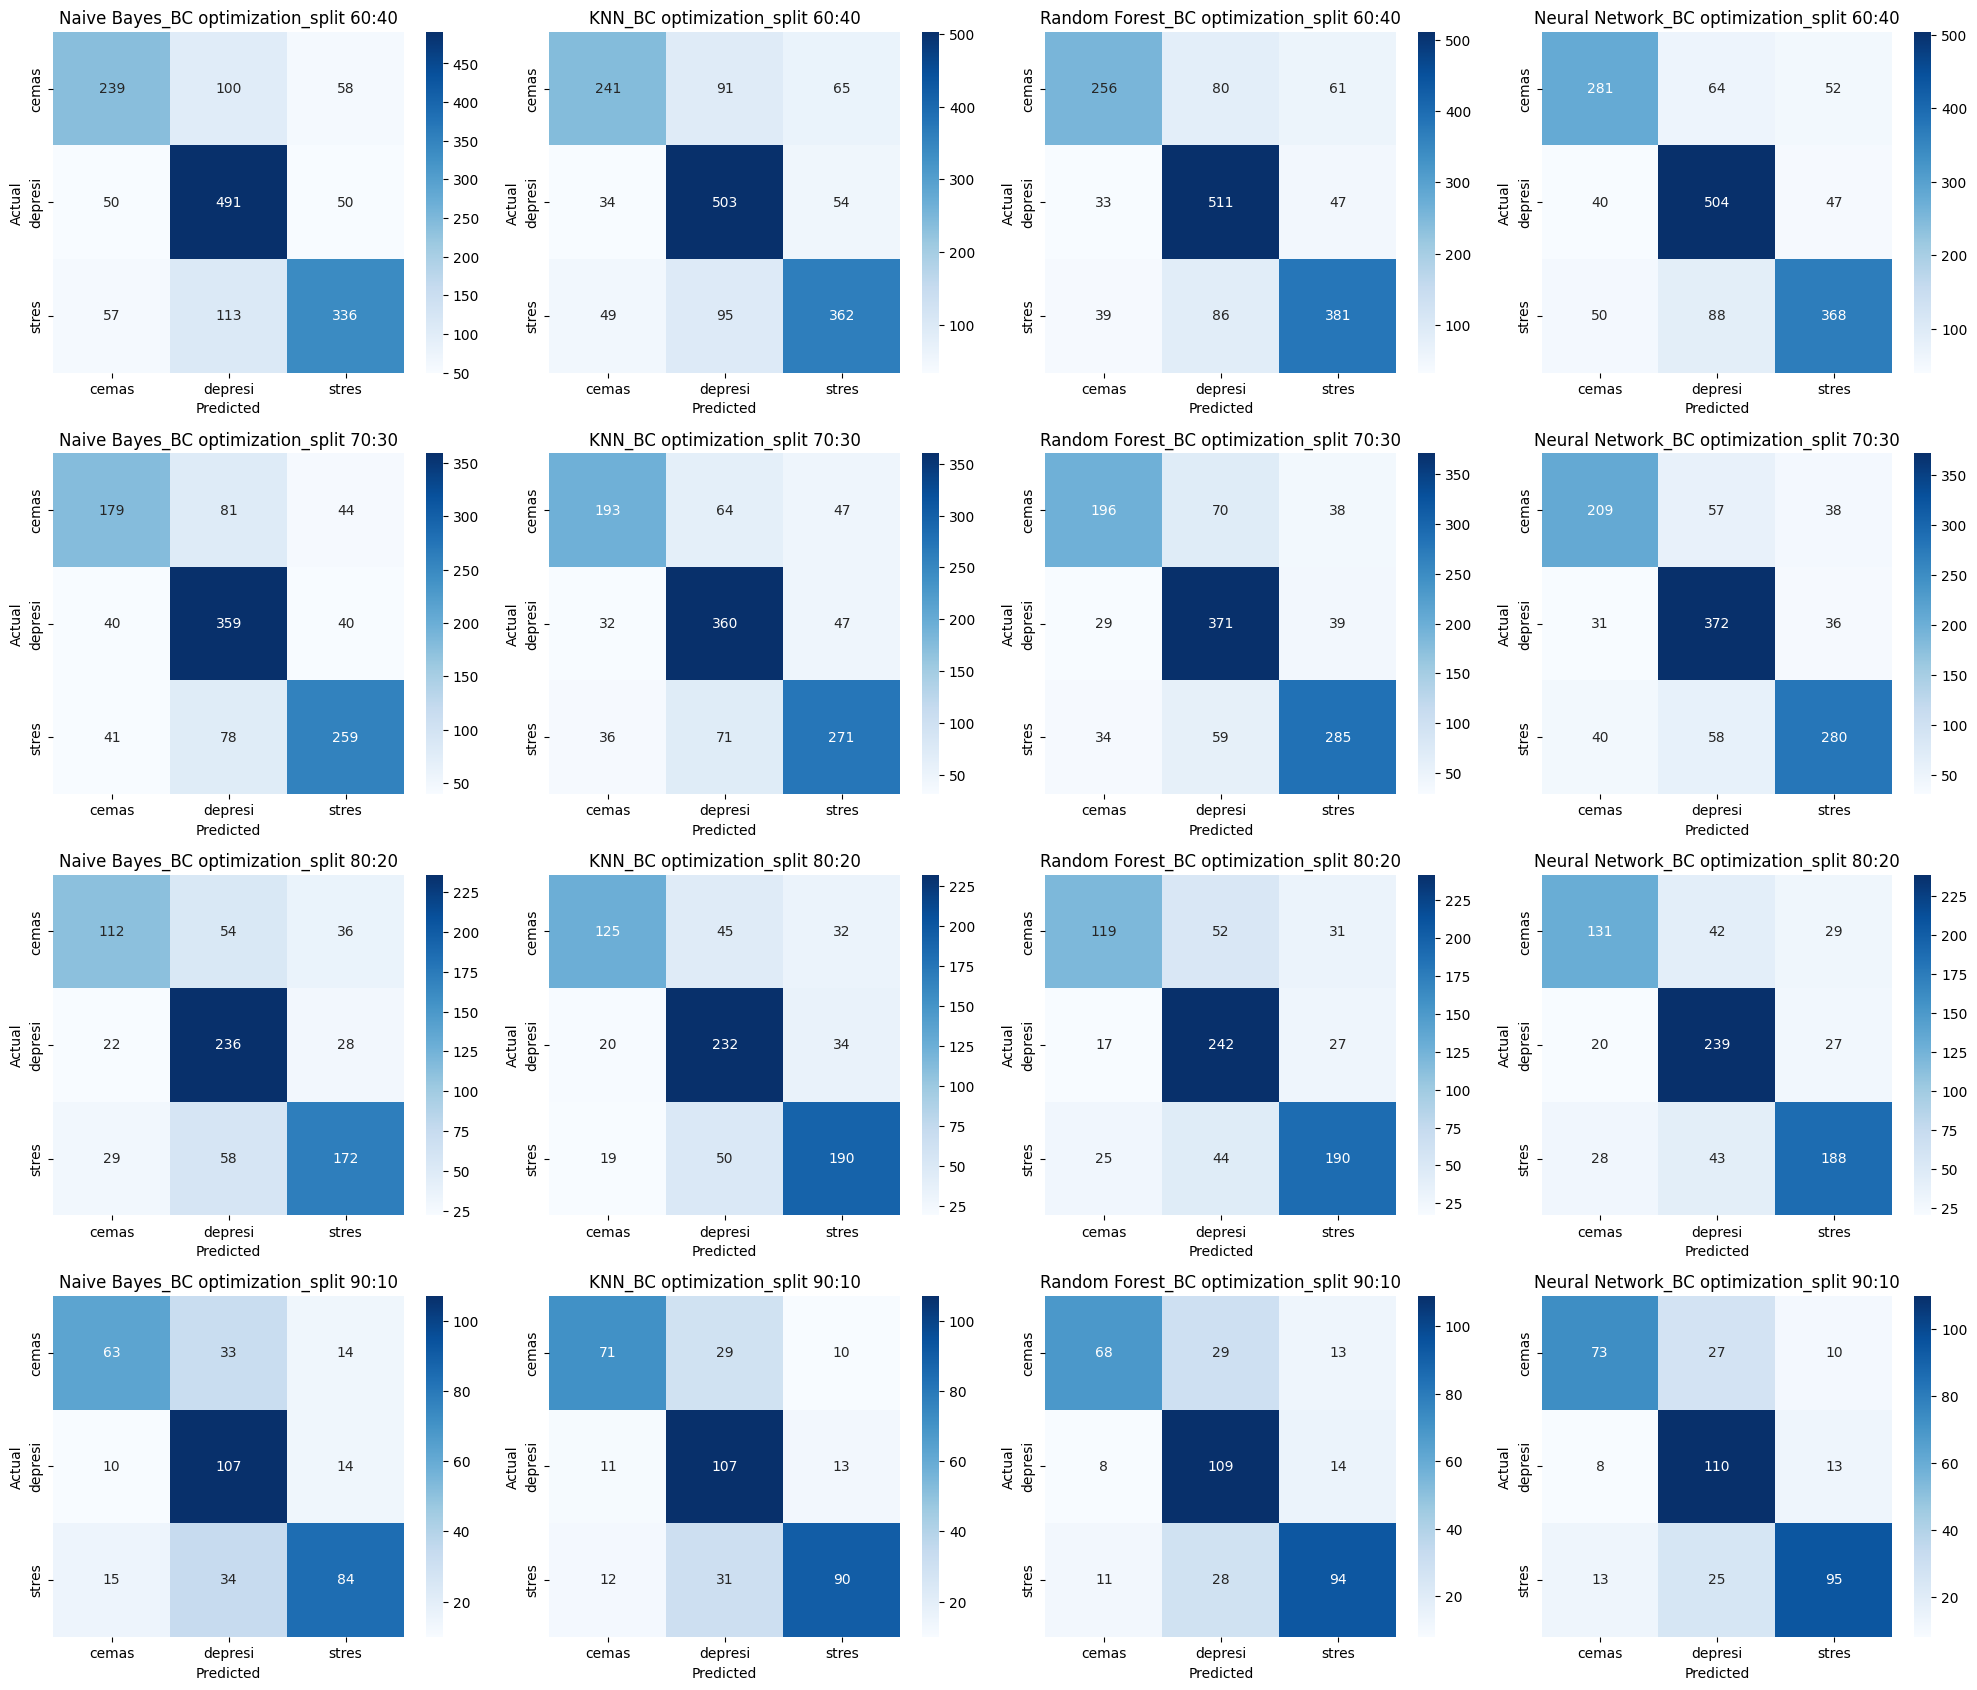

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_BC optimization_split')
    split_ratio = split_info.replace('_test', ':')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

Model,Naive Bayes,KNN,Random Forest,Neural Network
Split,,,,
60:40,0.713521,0.740295,0.768407,0.771754
70:30,0.710972,0.735058,0.760036,0.768064
80:20,0.696118,0.732262,0.737617,0.746988
90:10,0.679144,0.716578,0.724599,0.743316


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Naive Bayes_BC optimization_split 60:40,cemas,0.690751,0.602015,0.643338,397.0
1,Naive Bayes_BC optimization_split 60:40,depresi,0.697443,0.830795,0.758301,591.0
2,Naive Bayes_BC optimization_split 60:40,stres,0.756757,0.664032,0.707368,506.0
3,KNN_BC optimization_split 60:40,cemas,0.743827,0.607053,0.668516,397.0
4,KNN_BC optimization_split 60:40,depresi,0.730044,0.851100,0.785938,591.0
5,KNN_BC optimization_split 60:40,stres,0.752599,0.715415,0.733536,506.0
6,Random Forest_BC optimization_split 60:40,cemas,0.780488,0.644836,0.706207,397.0
7,Random Forest_BC optimization_split 60:40,depresi,0.754801,0.864636,0.805994,591.0
8,Random Forest_BC optimization_split 60:40,stres,0.779141,0.752964,0.765829,506.0
9,Neural Network_BC optimization_split 60:40,cemas,0.757412,0.707809,0.731771,397.0


# BC CrossV modelling

In [ ]:
# Define models
models = {
    'Naive Bayes': GaussianNB(var_smoothing=1e-9),
    'KNN': KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='auto', p=2),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, min_samples_leaf=2, bootstrap=True),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', learning_rate='adaptive', max_iter=1000, early_stopping=True, n_iter_no_change=5)
}

# Bagging classifier function
optimasi = 'BC optimization'
def get_bagging_clf(base_estimator):
    return BaggingClassifier(estimator=base_estimator, n_estimators=10, random_state=42, n_jobs=-1)

In [ ]:
# Define cross-validation folds
kf_values = [5, 10]

# Initialize results dictionary
results = {}

for k in kf_values:
    print(f'Processing cross-validation with k={k}')

    for model_name, model in models.items():
        print(f'  Training {model_name} with Bagging Classifier')

        # Create Bagging Classifier with the current model
        bagging_clf = get_bagging_clf(model)

        # Cross-validation predictions
        y_pred = cross_val_predict(bagging_clf, fitur, y, cv=k)

        # Evaluation
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y, y_pred)

        # Convert key to string, similar to the split validation
        result_key = f"{model_name}_{optimasi}_cross_val_k{k}"

        # Save results in the format similar to split validation
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),  # Convert array to list
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_bc_cv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing cross-validation with k=5
  Training Naive Bayes with Bagging Classifier
    Accuracy: 0.7248
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.71      0.59      0.64       956
     depresi       0.70      0.85      0.77      1456
       stres       0.77      0.68      0.72      1323

    accuracy                           0.72      3735
   macro avg       0.73      0.71      0.71      3735
weighted avg       0.73      0.72      0.72      3735

  Training KNN with Bagging Classifier
    Accuracy: 0.7443
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.73      0.62      0.67       956
     depresi       0.73      0.85      0.79      1456
       stres       0.78      0.71      0.74      1323

    accuracy                           0.74      3735
   macro avg       0.74      0.73      0.73      3735
weighted avg       0.75      0.74      0.74      3735

  Training Random F

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_bc_cv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

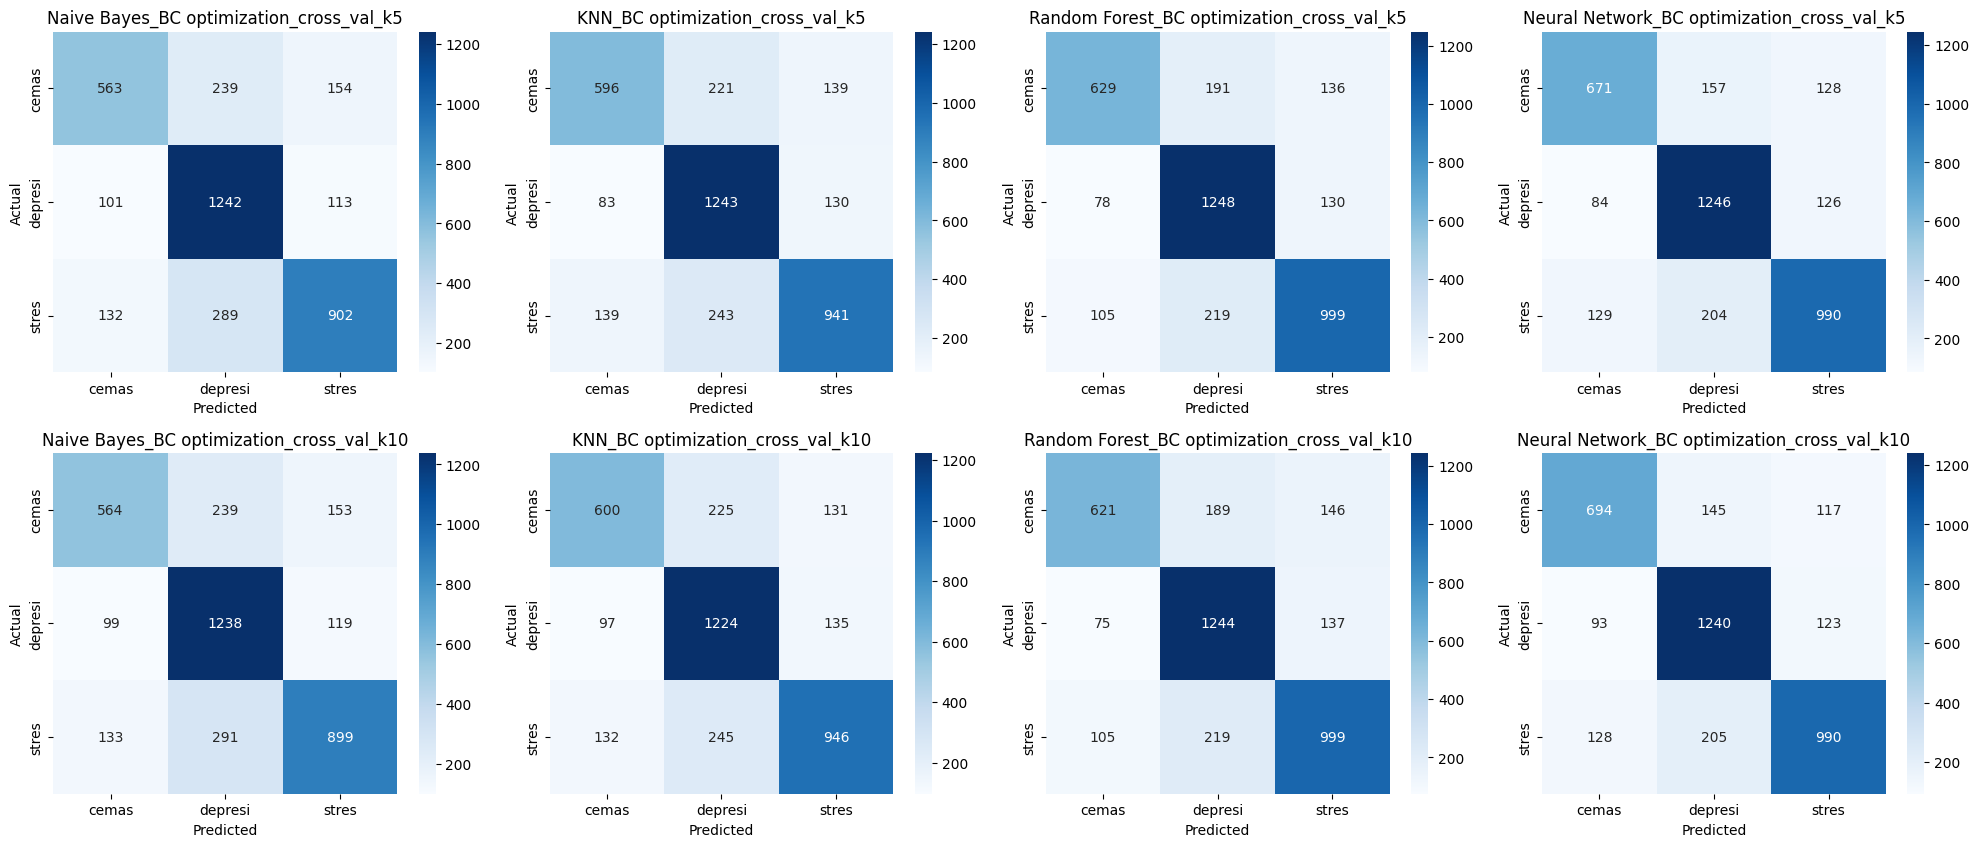

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    # if i >= 20:  # Limit to 20 subplots (5 rows x 4 columns)
    #     break
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_k')
    split_ratio = split_info.replace('cross_val_', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['K-Fold', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='K-Fold', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_BC optimization_cross_val', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

Model,Naive Bayes,KNN,Random Forest,Neural Network
K-Fold,,,,
10,0.723159,0.741633,0.766801,0.782865
5,0.724766,0.744311,0.770013,0.778313


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Naive Bayes_BC optimization_cross_val_k5,cemas,0.707286,0.588912,0.642694,956.0
1,Naive Bayes_BC optimization_cross_val_k5,depresi,0.701695,0.853022,0.769994,1456.0
2,Naive Bayes_BC optimization_cross_val_k5,stres,0.771600,0.681784,0.723917,1323.0
3,KNN_BC optimization_cross_val_k5,cemas,0.728606,0.623431,0.671928,956.0
4,KNN_BC optimization_cross_val_k5,depresi,0.728178,0.853709,0.785963,1456.0
5,KNN_BC optimization_cross_val_k5,stres,0.777686,0.711262,0.742992,1323.0
6,Random Forest_BC optimization_cross_val_k5,cemas,0.774631,0.657950,0.711538,956.0
7,Random Forest_BC optimization_cross_val_k5,depresi,0.752714,0.857143,0.801541,1456.0
8,Random Forest_BC optimization_cross_val_k5,stres,0.789723,0.755102,0.772025,1323.0
9,Neural Network_BC optimization_cross_val_k5,cemas,0.759050,0.701883,0.729348,956.0


# GA SplitV modelling

In [ ]:
models = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}
optimasi = 'GA optimization'

In [ ]:
splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]
results = {}

def get_ga_search(model):
    param_grids = {
        'GaussianNB': {'var_smoothing': Continuous(1e-9, 1e-7, distribution='log-uniform')},
        'KNeighborsClassifier': {'n_neighbors': Integer(10, 30), 'weights': Categorical(['distance']), 'p': Integer(1, 2)},
        'RandomForestClassifier': {'n_estimators': Integer(50, 100), 'max_depth': Integer(10, 20)},
        'MLPClassifier': {'hidden_layer_sizes': Categorical([(100,), (100, 50)]), 'learning_rate_init': Continuous(0.001, 0.005), 'learning_rate': Categorical(['adaptive']), 'early_stopping': Categorical([True])}
    }

    model_name = type(model).__name__
    if model_name not in param_grids:
        raise ValueError(f"Parameter grid for {model_name} not defined")

    ga_search = GASearchCV(
        estimator=model,
        param_grid=param_grids[type(model).__name__],
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=True,
        population_size=20,
        generations=4
    )
    return ga_search

In [ ]:
for train_size, test_size in splits:
    print(f'Processing split {int(train_size*100)}:{int(test_size*100)}')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fitur, y, test_size=test_size, random_state=42)

    for model_name, model in models.items():
        print(f'  Training {model_name} with GASearchCV')

        # Create GASearchCV with the current model
        ga_search = get_ga_search(model)
        ga_search.fit(X_train, y_train)
        y_pred = ga_search.predict(X_test)

        # Evaluation
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        # Convert tuple key to string
        result_key = f"{model_name}_{optimasi}_split {int(train_size*100)}:{int(test_size*100)}"

        # Save results
        results[result_key] = {
            'best_params': ga_search.best_params_,
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Best Params:', ga_search.best_params_)
        print('    Classification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_ga_sv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing split 60:40
  Training Naive Bayes with GASearchCV
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.722892	0          	0.722892   	0.722892   
1  	40    	0.722892	0          	0.722892   	0.722892   
2  	40    	0.722892	0          	0.722892   	0.722892   
3  	40    	0.722892	0          	0.722892   	0.722892   
4  	40    	0.722892	0          	0.722892   	0.722892   
    Accuracy: 0.7135
    Best Params: {'var_smoothing': 2.9121463184137342e-09}
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.70      0.60      0.65       397
     depresi       0.69      0.83      0.76       591
       stres       0.76      0.66      0.71       506

    accuracy                           0.71      1494
   macro avg       0.72      0.70      0.70      1494
weighted avg       0.72      0.71      0.71      1494

  Training KNN with GASearchCV
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.739514	0.00171

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_ga_sv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

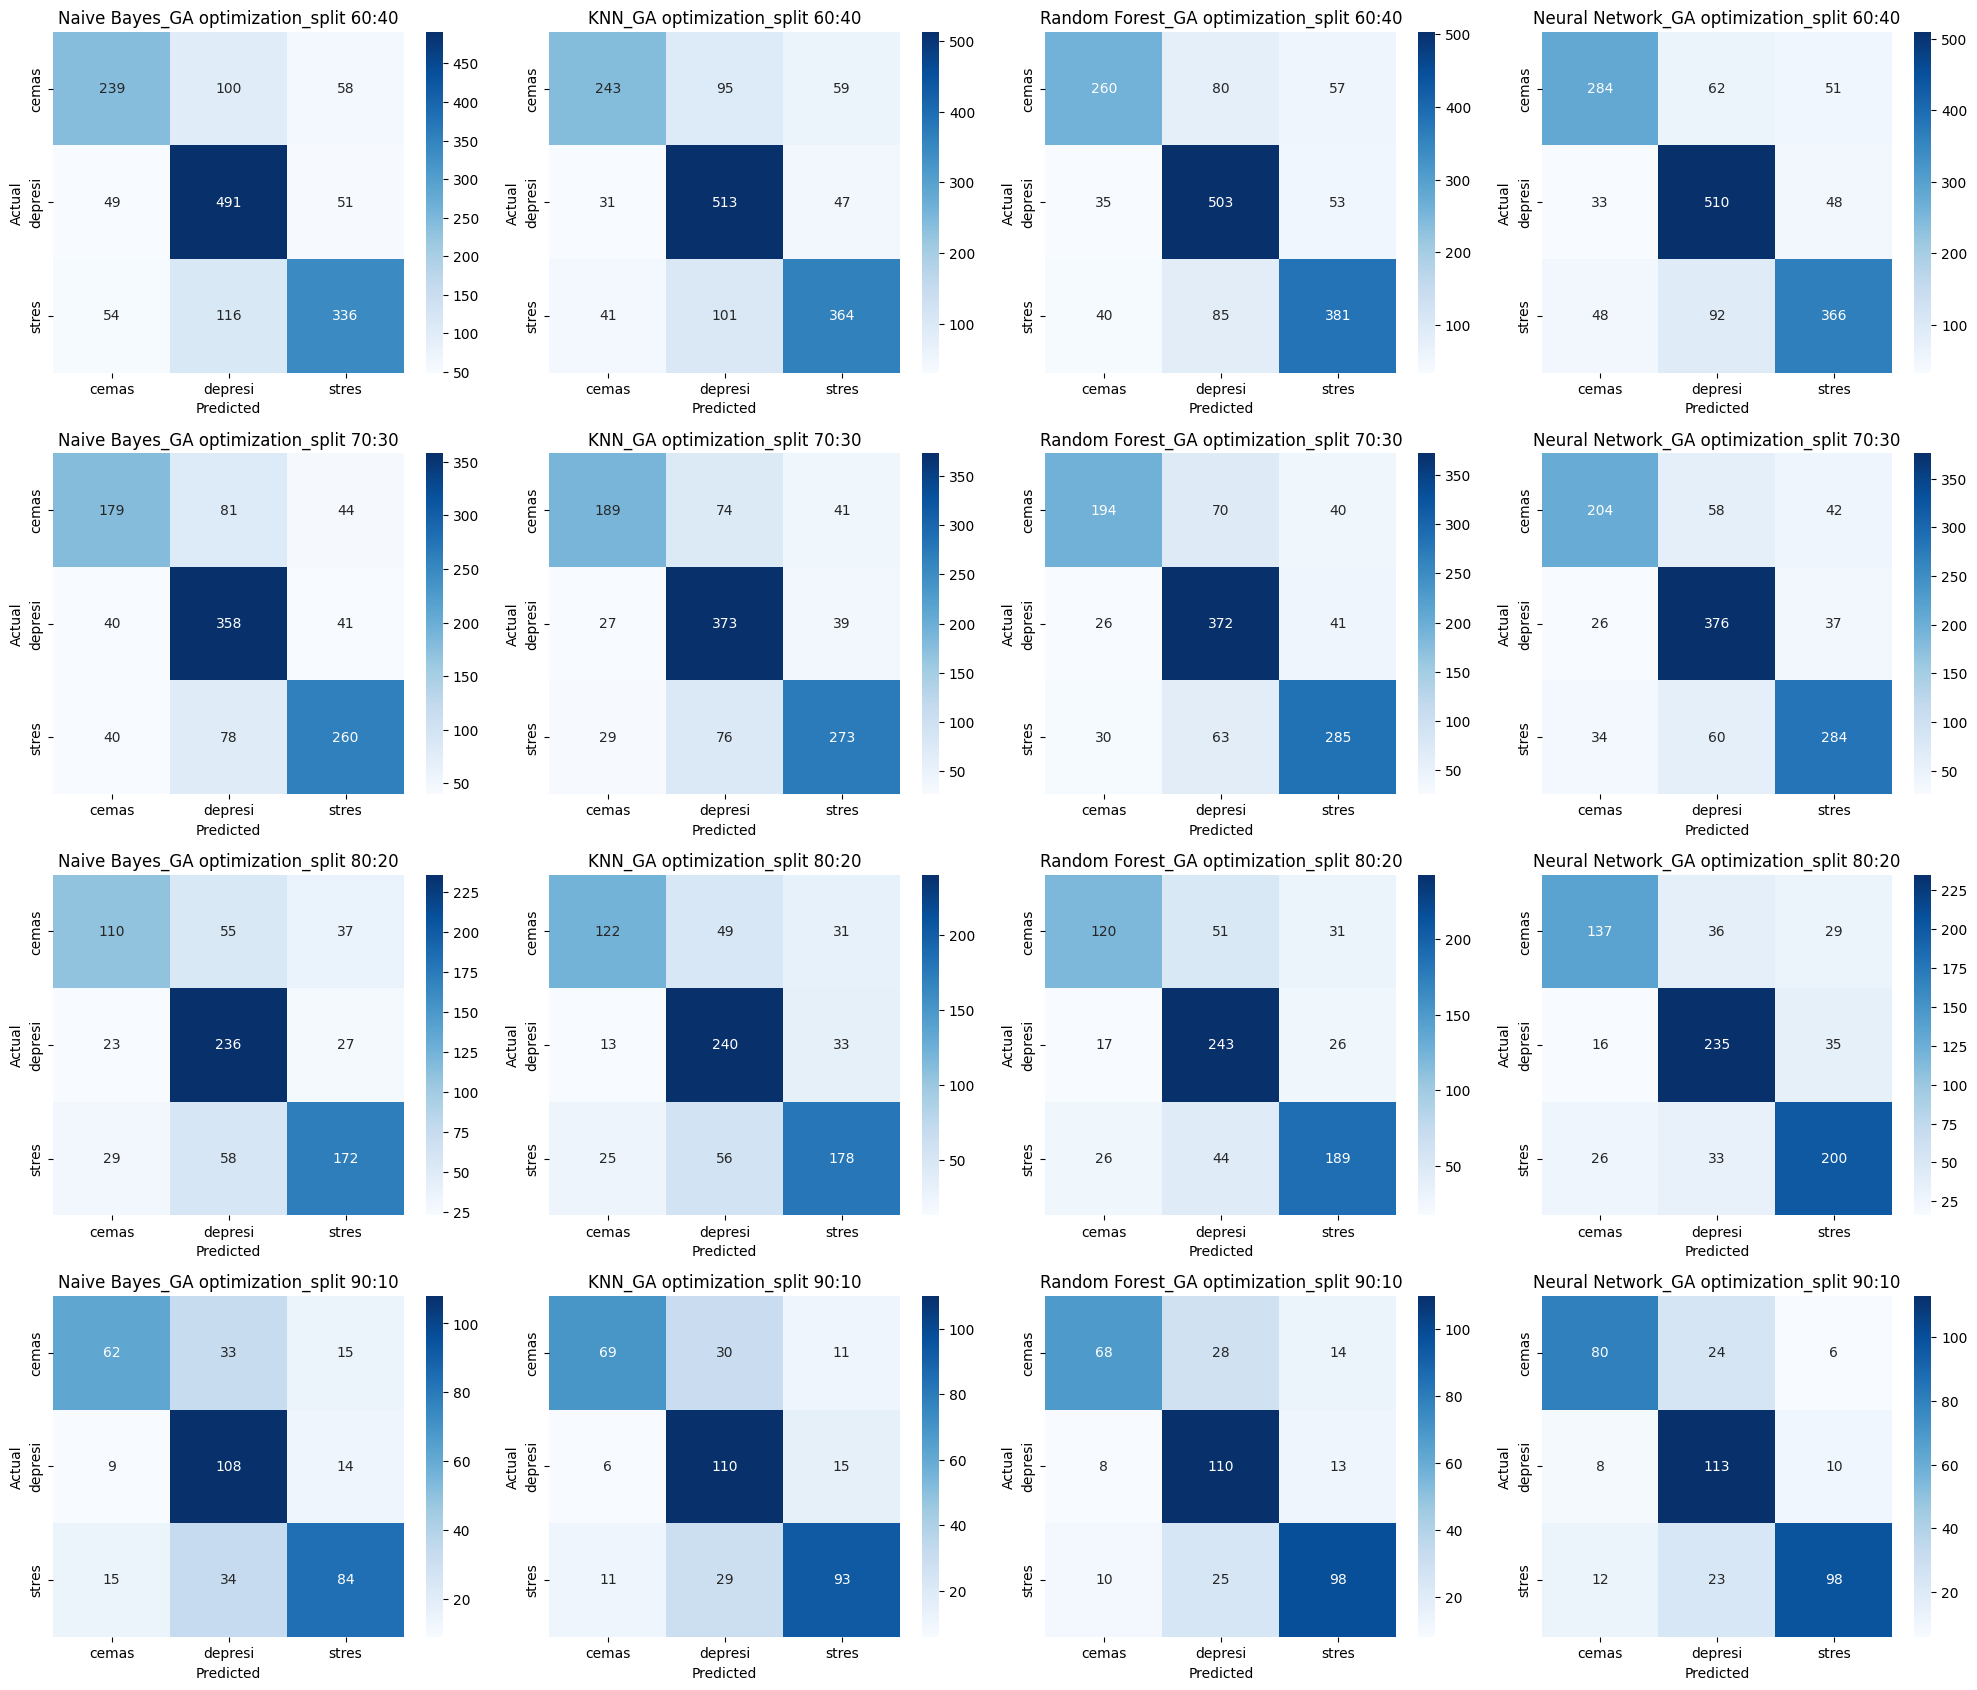

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_split ')
    split_ratio = split_info.replace('split ', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_GA optimization', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

Model,Naive Bayes,KNN,Random Forest,Neural Network
Split,,,,
60:40,0.713521,0.749665,0.765730,0.776439
70:30,0.710972,0.744871,0.759144,0.770740
80:20,0.693440,0.722892,0.738956,0.765730
90:10,0.679144,0.727273,0.737968,0.778075


In [ ]:
print(accuracy_table.columns)

Index(['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network'], dtype='object', name='Model')


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Naive Bayes_GA optimization_split 60:40,cemas,0.698830,0.602015,0.646820,397.0
1,Naive Bayes_GA optimization_split 60:40,depresi,0.694484,0.830795,0.756549,591.0
2,Naive Bayes_GA optimization_split 60:40,stres,0.755056,0.664032,0.706625,506.0
3,KNN_GA optimization_split 60:40,cemas,0.771429,0.612091,0.682584,397.0
4,KNN_GA optimization_split 60:40,depresi,0.723554,0.868020,0.789231,591.0
5,KNN_GA optimization_split 60:40,stres,0.774468,0.719368,0.745902,506.0
6,Random Forest_GA optimization_split 60:40,cemas,0.776119,0.654912,0.710383,397.0
7,Random Forest_GA optimization_split 60:40,depresi,0.752994,0.851100,0.799047,591.0
8,Random Forest_GA optimization_split 60:40,stres,0.775967,0.752964,0.764293,506.0
9,Neural Network_GA optimization_split 60:40,cemas,0.778082,0.715365,0.745407,397.0


# GA CrossV modelling

In [ ]:
models = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}
optimasi = 'GA optimization'

In [ ]:
def get_ga_search(model):
    param_grids = {
        'GaussianNB': {'var_smoothing': Continuous(1e-9, 1e-7, distribution='log-uniform')},
        'KNeighborsClassifier': {'n_neighbors': Integer(10, 30), 'weights': Categorical(['distance']), 'p': Integer(1, 2)},
        'RandomForestClassifier': {'n_estimators': Integer(50, 100), 'max_depth': Integer(10, 20)},
        'MLPClassifier': {'hidden_layer_sizes': Categorical([(100,), (100, 50)]), 'learning_rate_init': Continuous(0.001, 0.005), 'learning_rate': Categorical(['adaptive']), 'early_stopping': Categorical([True])}
    }

    model_name = type(model).__name__
    if model_name not in param_grids:
        raise ValueError(f"Parameter grid for {model_name} not defined")

    ga_search = GASearchCV(
        estimator=model,
        param_grid=param_grids[type(model).__name__],
        scoring='accuracy',
        cv=3,
        n_jobs=-1,
        verbose=True,
        population_size=20,
        generations=4
    )
    return ga_search

In [ ]:
# Nilai k untuk Cross Validation
k_values = [5, 10]

results = {}

for k in k_values:
    for model_name, model in models.items():
        print(f'Training {model_name} with GASearchCV and Cross Validation (k={k})')

        # Create GASearchCV with the current model
        ga_search = get_ga_search(model)
        ga_search.fit(fitur, y)

        # Cross validation predictions with k-fold
        y_pred = cross_val_predict(ga_search.best_estimator_, fitur, y, cv=k)

        # Evaluation
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y, y_pred)

        # Convert model name and k value to a valid JSON key
        result_key = f"{model_name}_{optimasi}_cross_val_k{k}"

        # Save results
        results[result_key] = {
            'best_params': ga_search.best_params_,
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Best Params:', ga_search.best_params_)
        print('    Classification Report:')
        print(classification_report(y, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_ga_cv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Training Naive Bayes with GASearchCV and Cross Validation (k=5)
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	20    	0.724498	1.11022e-16	0.724498   	0.724498   
1  	40    	0.724498	1.11022e-16	0.724498   	0.724498   
2  	40    	0.724498	1.11022e-16	0.724498   	0.724498   
3  	40    	0.724498	1.11022e-16	0.724498   	0.724498   
4  	40    	0.724498	1.11022e-16	0.724498   	0.724498   
    Accuracy: 0.7224
    Best Params: {'var_smoothing': 2.781908915505387e-08}
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.71      0.58      0.64       956
     depresi       0.70      0.85      0.77      1456
       stres       0.77      0.68      0.72      1323

    accuracy                           0.72      3735
   macro avg       0.72      0.71      0.71      3735
weighted avg       0.73      0.72      0.72      3735

Training KNN with GASearchCV and Cross Validation (k=5)
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0

## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_ga_cv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

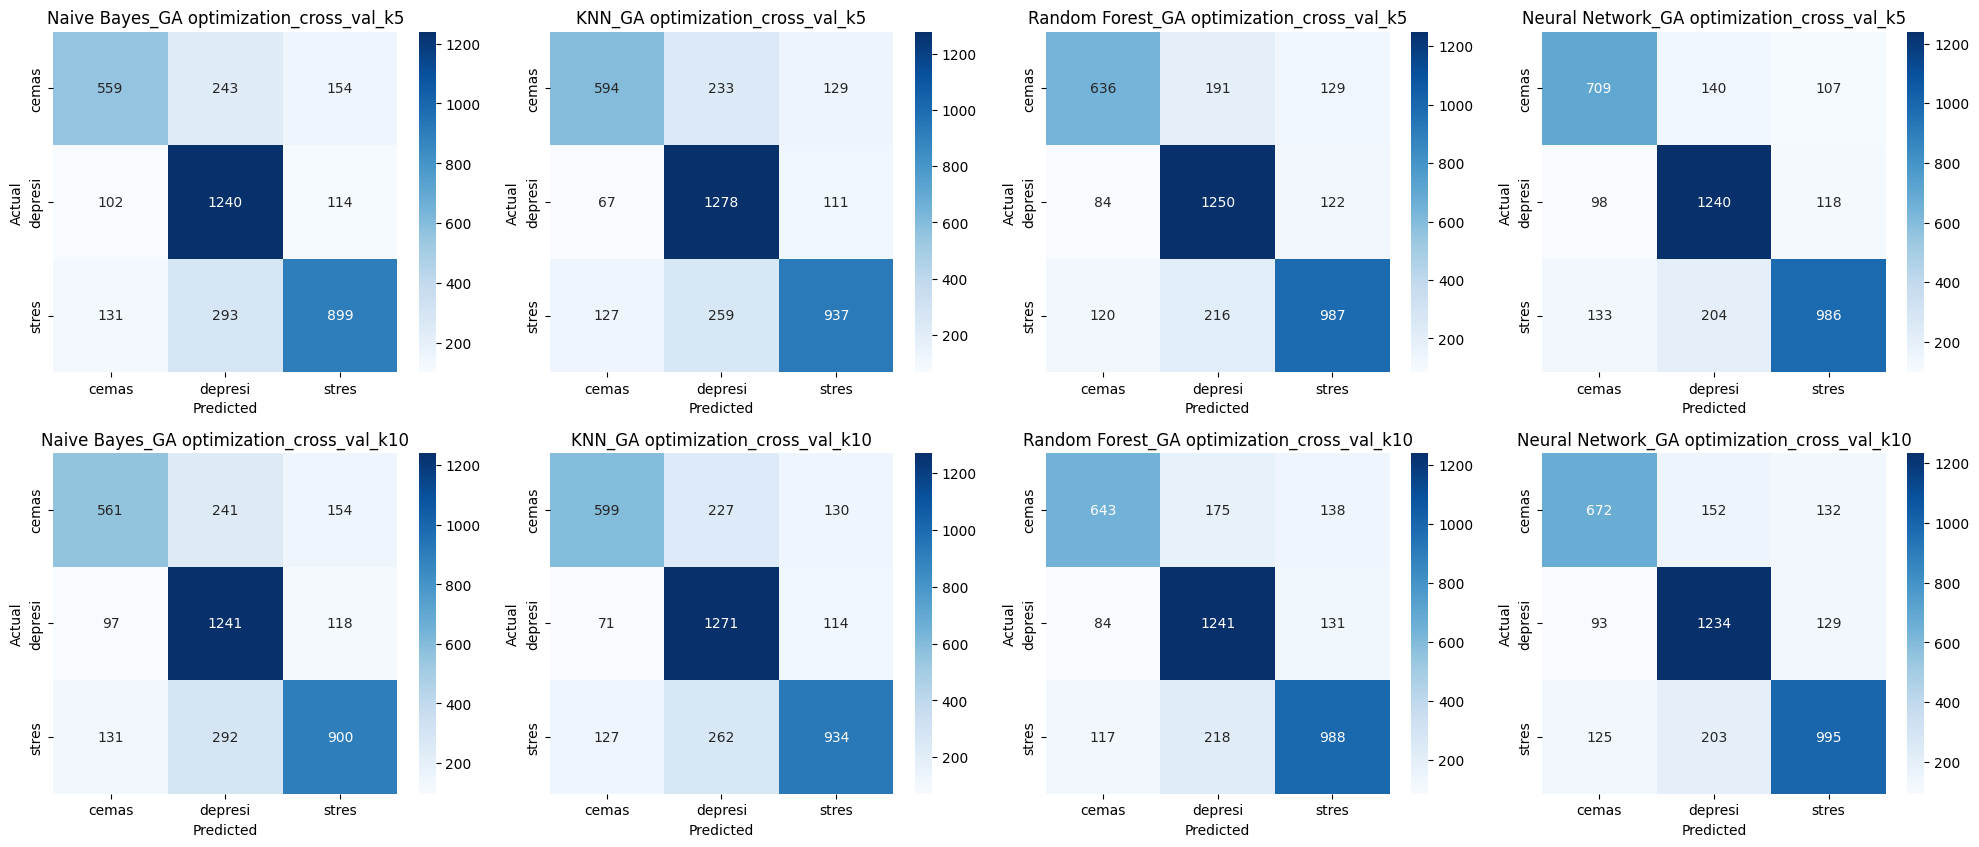

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_k')
    split_ratio = split_info.replace('cross_val_', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_GA optimization_cross_val', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

Model,Naive Bayes,KNN,Random Forest,Neural Network
Split,,,,
10,0.723427,0.750736,0.768942,0.776707
5,0.722356,0.752075,0.769210,0.785810


In [ ]:
print(accuracy_table.columns)

Index(['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network'], dtype='object', name='Model')


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Naive Bayes_GA optimization_cross_val_k5,cemas,0.705808,0.584728,0.639588,956.0
1,Naive Bayes_GA optimization_cross_val_k5,depresi,0.698198,0.851648,0.767327,1456.0
2,Naive Bayes_GA optimization_cross_val_k5,stres,0.770351,0.679516,0.722088,1323.0
3,KNN_GA optimization_cross_val_k5,cemas,0.753807,0.621339,0.681193,956.0
4,KNN_GA optimization_cross_val_k5,depresi,0.722034,0.877747,0.792312,1456.0
5,KNN_GA optimization_cross_val_k5,stres,0.796092,0.708239,0.749600,1323.0
6,Random Forest_GA optimization_cross_val_k5,cemas,0.757143,0.665272,0.708241,956.0
7,Random Forest_GA optimization_cross_val_k5,depresi,0.754375,0.858516,0.803084,1456.0
8,Random Forest_GA optimization_cross_val_k5,stres,0.797254,0.746032,0.770793,1323.0
9,Neural Network_GA optimization_cross_val_k5,cemas,0.754255,0.741632,0.747890,956.0


# Basic Split Validation Modelling (tanpa optimasi)

In [ ]:
# Define models
models = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}

# Define split ratios
splits = [(0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

# Initialize results dictionary
results = {}

for train_size, test_size in splits:
    print(f'Processing split {int(train_size*100)}:{int(test_size*100)}')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(fitur, y, test_size=test_size, random_state=42)

    for model_name, model in models.items():
        print(f'  Training {model_name} (basic model)')

        # Train the model directly
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluation
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)

        # Convert tuple key to string
        result_key = f"{model_name}_basic_split {int(train_size*100)}:{int(test_size*100)}"

        # Save results
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y_test, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_basic_sv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing split 60:40
  Training Naive Bayes (basic model)
    Accuracy: 0.7142
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.70      0.60      0.64       397
     depresi       0.69      0.83      0.76       591
       stres       0.76      0.66      0.71       506

    accuracy                           0.71      1494
   macro avg       0.72      0.70      0.70      1494
weighted avg       0.72      0.71      0.71      1494

  Training KNN (basic model)
    Accuracy: 0.7182
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.65      0.63      0.64       397
     depresi       0.72      0.81      0.76       591
       stres       0.77      0.68      0.72       506

    accuracy                           0.72      1494
   macro avg       0.71      0.71      0.71      1494
weighted avg       0.72      0.72      0.72      1494

  Training Random Forest (basic model)
    Accuracy: 

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


    Accuracy: 0.7851
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.78      0.74      0.76       397
     depresi       0.78      0.85      0.81       591
       stres       0.80      0.75      0.78       506

    accuracy                           0.79      1494
   macro avg       0.79      0.78      0.78      1494
weighted avg       0.79      0.79      0.78      1494

Processing split 70:30
  Training Naive Bayes (basic model)
    Accuracy: 0.7110
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.69      0.59      0.63       304
     depresi       0.69      0.82      0.75       439
       stres       0.76      0.69      0.72       378

    accuracy                           0.71      1121
   macro avg       0.71      0.70      0.70      1121
weighted avg       0.71      0.71      0.71      1121

  Training KNN (basic model)
    Accuracy: 0.7190
    Classification Report:
     

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


    Accuracy: 0.7788
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.73      0.74      0.74       304
     depresi       0.80      0.81      0.80       439
       stres       0.80      0.78      0.79       378

    accuracy                           0.78      1121
   macro avg       0.77      0.77      0.77      1121
weighted avg       0.78      0.78      0.78      1121

Processing split 80:20
  Training Naive Bayes (basic model)
    Accuracy: 0.6975
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.68      0.56      0.62       202
     depresi       0.67      0.82      0.74       286
       stres       0.74      0.67      0.70       259

    accuracy                           0.70       747
   macro avg       0.70      0.68      0.69       747
weighted avg       0.70      0.70      0.69       747

  Training KNN (basic model)
    Accuracy: 0.7122
    Classification Report:
     

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


    Accuracy: 0.7711
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.72      0.71      0.71       202
     depresi       0.76      0.86      0.80       286
       stres       0.84      0.72      0.78       259

    accuracy                           0.77       747
   macro avg       0.77      0.76      0.77       747
weighted avg       0.78      0.77      0.77       747

Processing split 90:10
  Training Naive Bayes (basic model)
    Accuracy: 0.6818
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.71      0.58      0.64       110
     depresi       0.62      0.82      0.70       131
       stres       0.76      0.63      0.69       133

    accuracy                           0.68       374
   macro avg       0.70      0.68      0.68       374
weighted avg       0.69      0.68      0.68       374

  Training KNN (basic model)
    Accuracy: 0.7380
    Classification Report:
     

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_basic_sv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

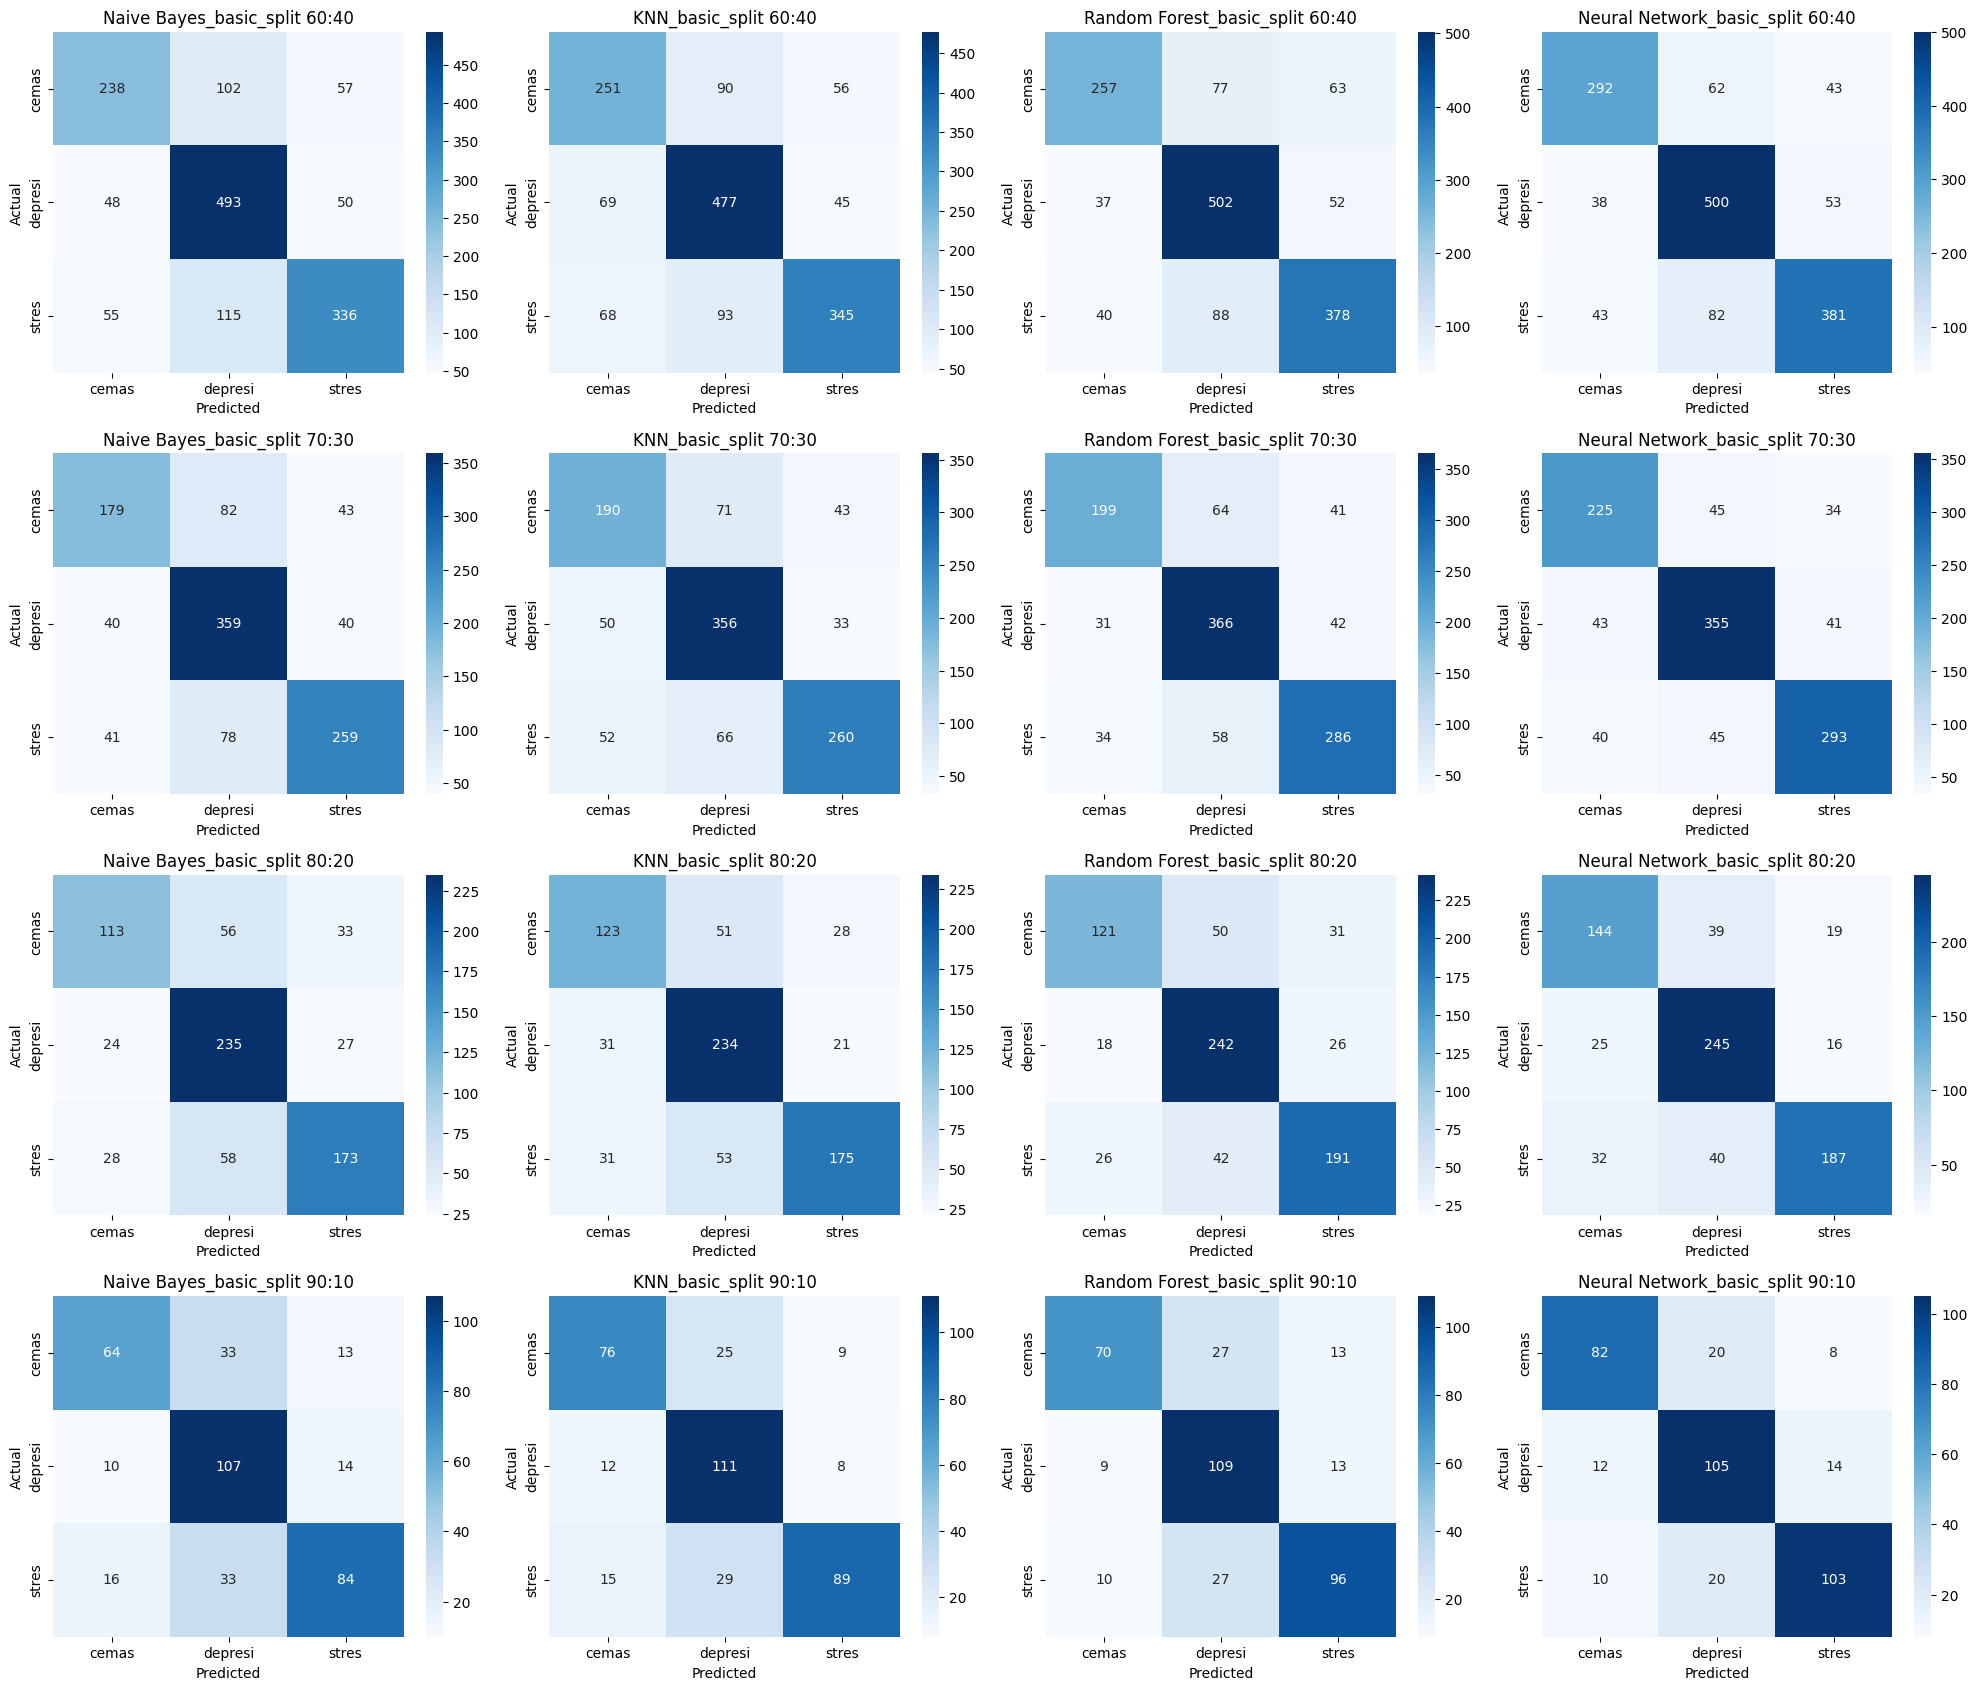

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_basic_split')
    split_ratio = split_info.replace('_test', ':')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['Split', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='Split', columns='Model', values='Accuracy')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

Model,Naive Bayes,KNN,Random Forest,Neural Network
Split,,,,
60:40,0.714190,0.718206,0.761044,0.785141
70:30,0.710972,0.719001,0.759144,0.778769
80:20,0.697456,0.712182,0.741633,0.771084
90:10,0.681818,0.737968,0.735294,0.775401


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Naive Bayes_basic_split 60:40,cemas,0.697947,0.599496,0.644986,397.0
1,Naive Bayes_basic_split 60:40,depresi,0.694366,0.834179,0.757879,591.0
2,Naive Bayes_basic_split 60:40,stres,0.758465,0.664032,0.708114,506.0
3,KNN_basic_split 60:40,cemas,0.646907,0.632242,0.639490,397.0
4,KNN_basic_split 60:40,depresi,0.722727,0.807107,0.762590,591.0
5,KNN_basic_split 60:40,stres,0.773543,0.681818,0.724790,506.0
6,Random Forest_basic_split 60:40,cemas,0.769461,0.647355,0.703146,397.0
7,Random Forest_basic_split 60:40,depresi,0.752624,0.849408,0.798092,591.0
8,Random Forest_basic_split 60:40,stres,0.766734,0.747036,0.756757,506.0
9,Neural Network_basic_split 60:40,cemas,0.782842,0.735516,0.758442,397.0


# Basic Cross Validation Modelling (tanpa optimasi)

In [ ]:
# Define models
models = {
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Neural Network': MLPClassifier()
}

# Define cross-validation folds
kf_values = [5, 10]

# Initialize results dictionary
results = {}

for k in kf_values:
    print(f'Processing cross-validation with k={k}')

    for model_name, model in models.items():
        print(f'  Training {model_name} (basic model)')

        # Cross-validation predictions
        y_pred = cross_val_predict(model, fitur, y, cv=k)

        # Evaluation
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y, y_pred)

        # Convert key to string, similar to the split validation
        result_key = f"{model_name}_basic_cross_val_k{k}"

        # Save results in the format similar to split validation
        results[result_key] = {
            'confusion_matrix': conf_matrix.tolist(),
            'classification_report': class_report,
            'accuracy': accuracy
        }

        print(f'    Accuracy: {accuracy:.4f}')
        print('    Classification Report:')
        print(classification_report(y, y_pred, zero_division=0))

# Save results to a JSON file
with open(path + f'{nama_ekstraksi}_basic_cv_experiment_results.json', 'w') as f:
    json.dump(results, f, indent=4)

Processing cross-validation with k=5
  Training Naive Bayes (basic model)
    Accuracy: 0.7234
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.71      0.59      0.64       956
     depresi       0.70      0.85      0.77      1456
       stres       0.77      0.68      0.72      1323

    accuracy                           0.72      3735
   macro avg       0.73      0.71      0.71      3735
weighted avg       0.73      0.72      0.72      3735

  Training KNN (basic model)
    Accuracy: 0.7307
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.65      0.67      0.66       956
     depresi       0.72      0.82      0.77      1456
       stres       0.82      0.67      0.74      1323

    accuracy                           0.73      3735
   macro avg       0.73      0.72      0.72      3735
weighted avg       0.74      0.73      0.73      3735

  Training Random Forest (basic model)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

    Accuracy: 0.7866
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.74      0.73      0.74       956
     depresi       0.79      0.83      0.81      1456
       stres       0.81      0.77      0.79      1323

    accuracy                           0.79      3735
   macro avg       0.78      0.78      0.78      3735
weighted avg       0.79      0.79      0.79      3735

Processing cross-validation with k=10
  Training Naive Bayes (basic model)
    Accuracy: 0.7261
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.71      0.60      0.65       956
     depresi       0.70      0.85      0.77      1456
       stres       0.77      0.68      0.72      1323

    accuracy                           0.73      3735
   macro avg       0.73      0.71      0.71      3735
weighted avg       0.73      0.73      0.72      3735

  Training KNN (basic model)
    Accuracy: 0.7309
    Classificatio

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

    Accuracy: 0.7901
    Classification Report:
              precision    recall  f1-score   support

       cemas       0.76      0.75      0.75       956
     depresi       0.79      0.85      0.82      1456
       stres       0.82      0.76      0.79      1323

    accuracy                           0.79      3735
   macro avg       0.79      0.78      0.79      3735
weighted avg       0.79      0.79      0.79      3735



## Menampilkan hasil model

In [ ]:
import json

# Membaca file JSON
with open(path + f'{nama_ekstraksi}_basic_cv_experiment_results.json', 'r') as f:
    results = json.load(f)

### Confusion Matrix (heatmap)

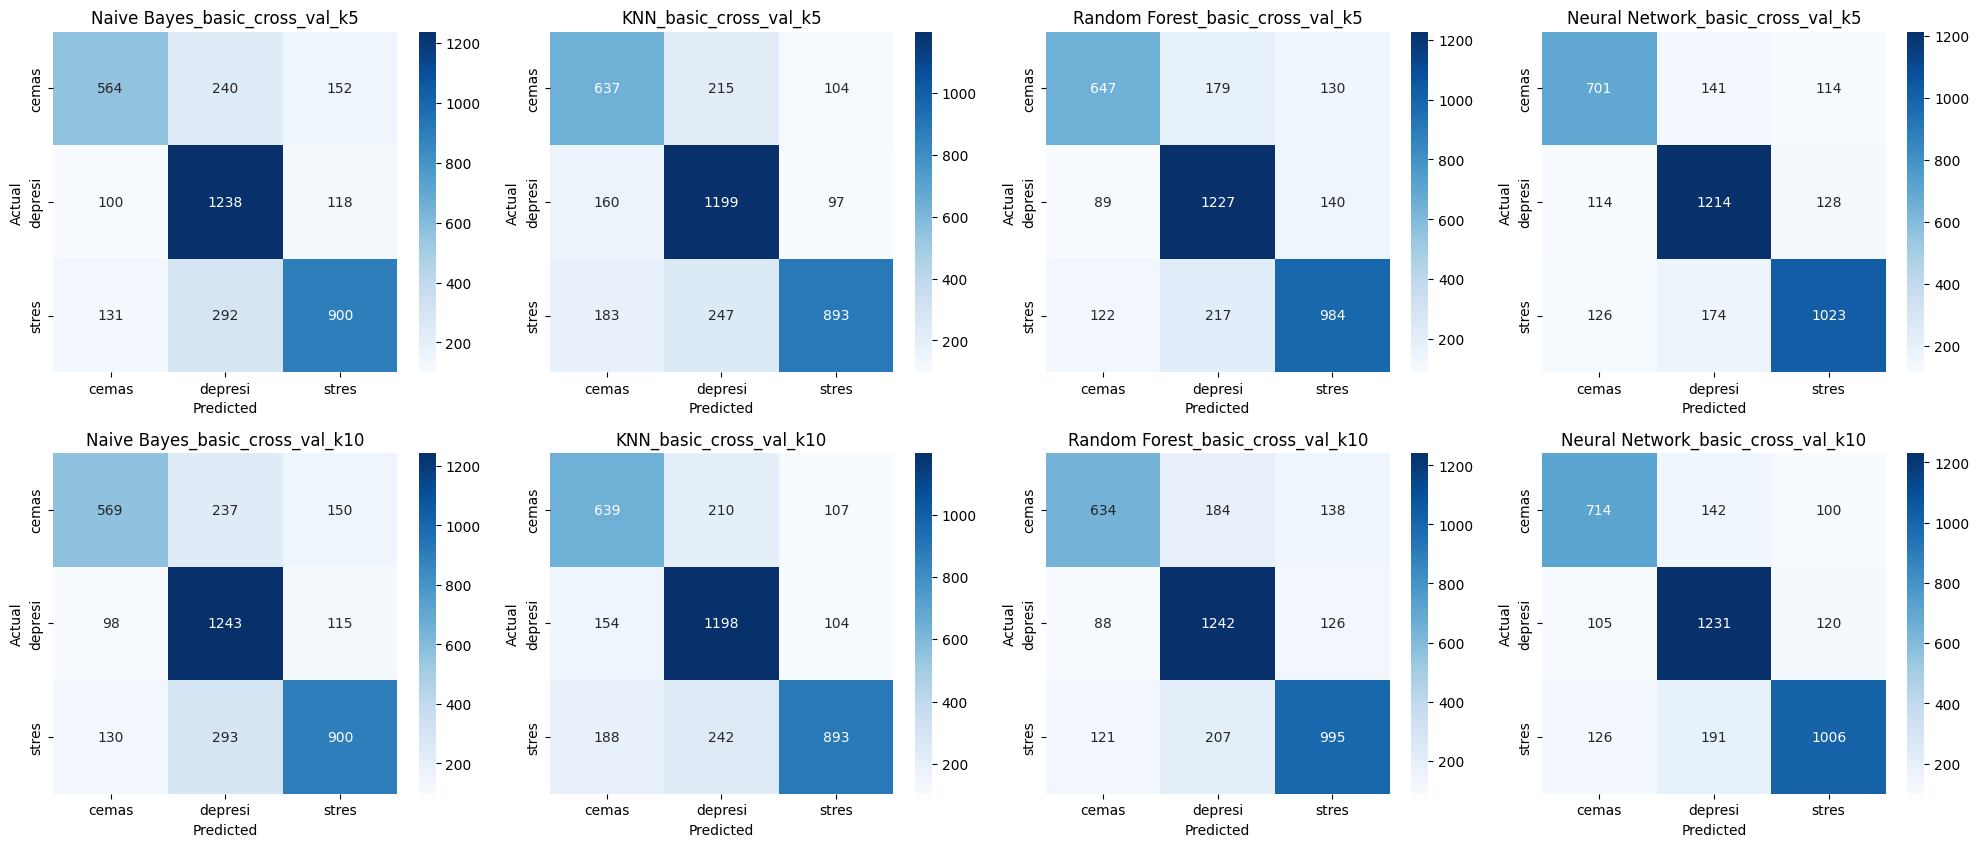

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Known labels
labels = ["cemas", "depresi", "stres"]

# Set the figure size
plt.rcParams['figure.figsize'] = [20, 25]

# Create subplots for each confusion matrix
for i, (key, value) in enumerate(results.items()):
    # if i >= 20:  # Limit to 20 subplots (5 rows x 4 columns)
    #     break
    cm = np.array(value['confusion_matrix'])
    plt.subplot(6, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(key)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axis("on")

# Show the plots
plt.tight_layout()
plt.show()

### Evaluasi kinerja model

In [ ]:
# Inisialisasi list untuk menyimpan data
data = []

# Ekstrak split dan model dari keys di results
for key, value in results.items():
    model_name, split_info = key.split(f'_k')
    split_ratio = split_info.replace('cross_val_', '')
    accuracy = value['accuracy']

    # Tambahkan data ke dalam list
    data.append([split_ratio, model_name, accuracy])

# Konversi list ke DataFrame
accuracy_table = pd.DataFrame(data, columns=['K-Fold', 'Model', 'Accuracy'])

# Pivot DataFrame agar model menjadi kolom
accuracy_table = accuracy_table.pivot(index='K-Fold', columns='Model', values='Accuracy')

# Rename columns to remove the extra text
accuracy_table.columns = accuracy_table.columns.str.replace('_basic_cross_val', '')

# Atur ulang kolom sesuai urutan yang diinginkan
accuracy_table = accuracy_table[['Naive Bayes', 'KNN', 'Random Forest', 'Neural Network']]

# Tampilkan tabel akurasi
accuracy_table

Model,Naive Bayes,KNN,Random Forest,Neural Network
K-Fold,,,,
10,0.726104,0.730924,0.768675,0.790094
5,0.723427,0.730656,0.765194,0.786613


In [ ]:
# Initialize an empty list to store data for the DataFrame
data = []

# Extracting data for each model and split
for experiment_name, result in results.items():
    for label, metrics in result['classification_report'].items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Skip overall metrics
            row = {
                'Experiment': experiment_name,
                'Label': label,
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support']
            }
            data.append(row)

# Create DataFrame from the data list
df_results = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df_results

,Experiment,Label,Precision,Recall,F1-Score,Support
0,Naive Bayes_basic_cross_val_k5,cemas,0.709434,0.589958,0.644203,956.0
1,Naive Bayes_basic_cross_val_k5,depresi,0.699435,0.850275,0.767514,1456.0
2,Naive Bayes_basic_cross_val_k5,stres,0.769231,0.680272,0.722022,1323.0
3,KNN_basic_cross_val_k5,cemas,0.650000,0.666318,0.658058,956.0
4,KNN_basic_cross_val_k5,depresi,0.721854,0.823489,0.769329,1456.0
5,KNN_basic_cross_val_k5,stres,0.816271,0.674981,0.738933,1323.0
6,Random Forest_basic_cross_val_k5,cemas,0.754079,0.676778,0.713341,956.0
7,Random Forest_basic_cross_val_k5,depresi,0.756007,0.842720,0.797012,1456.0
8,Random Forest_basic_cross_val_k5,stres,0.784689,0.743764,0.763679,1323.0
9,Neural Network_basic_cross_val_k5,cemas,0.744952,0.733264,0.739062,956.0
